<h1>Decision Tree Modeling</h1>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

#importing sklearn
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
#saving scraped data to pandas dataframes
politics = pd.read_csv("../data/Politics_data_full.csv", index_col = 0)
politics.text.replace('[]', np.nan, inplace=True)
politics = politics.dropna(subset=["text"]).reset_index(drop=True)

money = pd.read_csv("../data/Medium_Money_Data_Final.csv", index_col = 0)
money.text.replace("[]", np.nan, inplace=True)
money = money.dropna(subset=["text"]).reset_index(drop=True)

sports = pd.read_csv("../data/medium-sports-data.csv", index_col = 0)
sports.text.replace("[]", np.nan, inplace=True)
sports = sports.dropna(subset=["text"]).reset_index(drop=True)

tech = pd.read_csv("../data/medium-tech-data.csv", index_col = 0)
tech.text.replace("[]", np.nan, inplace=True)
tech = tech.dropna(subset=["text"]).reset_index(drop=True)

politics.text, money.text, sports.text, tech.text

(0       ['[Photo courtesy of Pixabay, There is a diffe...
 1       ['[image courtesy of Pixabay, Last night I was...
 2       ['[I can’t write about politics today. It’s to...
 3       ['[Lethal autonomous weapon systems (LAWS) are...
 4       ['[Photo courtesy of Pixabay, There is a diffe...
                               ...                        
 3328    ['[Candace Owens, an African-American commenta...
 3329    ['[Byrne Hobart makes some interesting points ...
 3330    ['[If karma were to exist, it’s hard to imagin...
 3331    ['[I’ve written before about potentially fatal...
 3332    ['[Migration scored with film audiences in 201...
 Name: text, Length: 3333, dtype: object,
 0       ['[Potential ways to Save using a Free Library...
 1       ['[By Tara Lachapelle, Netflix Inc. broke the ...
 2       ['[By Noah Smith, The great irony of the ironi...
 3       ['[By Faye Flam, It’s become a kind of sport t...
 4       ['[The Apple Card, a collaborative product bet...
              

<h2>NLP</h2>

In [3]:
#down sample
np.random.seed = 42
pol = politics.sample(2000, replace= False)[["text"]].reset_index(drop=True)
mon = money.sample(len(money), replace = False)[["text"]].reset_index(drop=True)
spo = sports.sample(len(sports), replace = False)[["text"]].reset_index(drop=True)
tec = tech.sample(2000, replace = False)[["text"]].reset_index(drop=True)

In [4]:
#adding on the labels:
pol["label"] = [0] * len(pol)
mon["label"] = [1] * len(mon)
spo["label"] = [2] * len(spo)
tec["label"] = [3] * len(tec)

In [5]:
#need to split them up to train and test
len_mon = len(mon)
len_pol = len(pol)
len_tec = len(tec)
len_spo = len(spo)

In [6]:
#need to get train set
len_train_mon = int(len_mon * .80)
len_train_pol = int(len_pol * .80)
len_train_tec = int(len_tec * .80)
len_train_spo = int(len_spo * .80)

In [7]:
#train sets
train_mon = mon.iloc[:len_train_mon]
train_pol = pol.iloc[:len_train_pol]
train_tec = tec.iloc[:len_train_tec]
train_spo = spo.iloc[:len_train_spo]

#test sets
test_mon = mon.iloc[len_train_mon:]
test_pol = pol.iloc[len_train_pol:]
test_tec = tec.iloc[len_train_tec:]
test_spo = spo.iloc[len_train_spo:]

In [8]:
#need to combine all categories together for train
train = pd.concat([train_mon, train_pol, train_tec, train_spo],axis=0)

#need to combine all categories together for test
test = pd.concat([test_mon, test_pol, test_tec, test_spo],axis=0)

In [9]:
train = train.sample(frac = 1, replace = False).reset_index(drop=True)
test = test.sample(frac = 1, replace = False).reset_index(drop=True)

In [10]:
#get rid of null values
train = train[~pd.isnull(train["text"])]
test = test[~pd.isnull(test["text"])]

<h2>Hyperparameter Tuning</h2>

In [11]:
#dict to keep my results:
tuning_dict = {}
i = 0

#making vectorizer:
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 100)

#a makeshift gridsearch:
for max_depth_i in range(1, 26):
    for min_samples_split_i in np.arange(.01, 0.26, .01):
        i = i + 1
        print(i)
        
        #this is how you create a basic decision tree
        dt = DecisionTreeClassifier(max_depth = max_depth_i, min_samples_split = min_samples_split_i)

        #cross validation:
        kfold = KFold(n_splits = 3)
        for train_index, test_index in kfold.split(train):
            #split into train and test:
            X_train, X_test = train["text"].iloc[train_index], train['text'].iloc[test_index]
            Y_train, Y_test = train["label"].iloc[train_index], train['label'].iloc[test_index]

            #fit vectorizer on the train data:
            X_train_trans = vector.fit_transform(X_train)

            #DO NOT refit it onto the test data!
            X_test_trans = vector.transform(X_test)

            #fit on the decision tree
            dt.fit(X_train_trans, Y_train)
            test_scores = dt.score(X_test_trans, Y_test)
            train_scores = dt.score(X_train_trans, Y_train)

            #add to the dictionary

            tuning_dict[i] = {
                "train": np.mean(train_scores), 
                "test": np.mean(test_scores), 
                "max_depth": max_depth_i, 
                "min_samples_split": min_samples_split_i
            }

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [12]:
tuning_dict

{1: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.01},
 2: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.02},
 3: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.03},
 4: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.04},
 5: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.05},
 6: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.060000000000000005},
 7: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.06999999999999999},
 8: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.08},
 9: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,


In [13]:
tuning_table = pd.DataFrame.from_dict(tuning_dict)

In [18]:
tuning_table_t = tuning_table.transpose().sort_values("train", ascending=False)
md = tuning_table_t["max_depth"].iloc[0]
mss = tuning_table_t["min_samples_split"].iloc[0]
tuning_table.transpose()

,train,test,max_depth,min_samples_split
1,0.445158,0.459385,1.0,0.01
2,0.445158,0.459385,1.0,0.02
3,0.445158,0.459385,1.0,0.03
4,0.445158,0.459385,1.0,0.04
5,0.445158,0.459385,1.0,0.05
...,...,...,...,...
621,0.775815,0.733364,25.0,0.21
622,0.775815,0.733364,25.0,0.22
623,0.761358,0.725562,25.0,0.23
624,0.761358,0.725562,25.0,0.24


In [19]:
#optimized decision tree
dt = DecisionTreeClassifier(max_depth = md, min_samples_split = mss)

In [21]:
#final vector written here (no max number of features)
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = None)

#fit the tfidf on all the train data:
train_final = vector.fit_transform(train["text"])

#the final transformation and fitting before using the test data:
test_final = vector.transform(test["text"])

In [22]:
#fit model on FULL train data
dt.fit(train_final, train["label"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25.0,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [23]:
#get predictions from the decision tree
predictions = dt.predict(test_final)
predictions

array([0, 1, 3, ..., 1, 2, 0], dtype=int64)

In [24]:
#get the confusion matrix:
cm = confusion_matrix(test["label"], predictions)
cm

array([[337,  26,  17,  20],
       [ 32, 279,   7,  12],
       [ 19,   8, 348, 130],
       [ 13,  11,  14, 362]], dtype=int64)

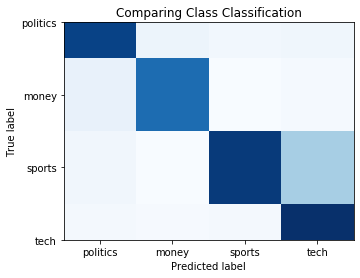

In [26]:
#plotting the confusion matrix
fig, ax = plt.subplots()
classes = ["politics", "money", "sports", "tech"]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Comparing Class Classification",
           ylabel='True label',
           xlabel='Predicted label');